In [17]:
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch
from im2im.main import load_model
import time
import cv2
import numpy as np
import gc
import math
from PIL import Image

In [26]:
cap = cv2.VideoCapture("/home/windowsuser/woman.mp4")

resized_frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    resized_frames.append(
        np.array(
            cv2.resize(
                cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 
                (640, 384)
            )
        )
    )

resized_frames = np.stack(resized_frames, axis=0)
batch = resized_frames[range(0, 16)]
print(batch.shape, batch.dtype)


(16, 384, 640, 3) uint8


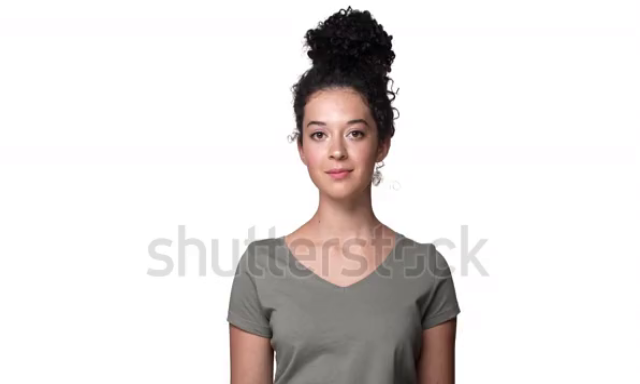

In [27]:
img = Image.fromarray(resized_frames[0])
img

In [3]:
device = xm.xla_device()
model = load_model("im2im-sswm", device)

In [4]:
def prep_batch(batch):
    # batch should be a torch tensor, uint8, 0-255, (B, H, W, C)
    batch = batch.permute(0,3,1,2) # (B, H, W, C) -> (B, C, H, W)
    batch = batch.to(device).to(torch.float32).div(255).to(memory_format=torch.contiguous_format) # batch is now a tensor, float32, 0-1
    _bs, _c, _h, _w = batch.shape
    right = math.ceil(_w / model.ksize) * model.ksize - _w
    bottom = math.ceil(_h / model.ksize) * model.ksize - _h
    batch = torch.nn.functional.pad(batch, [0, right, 0, bottom], mode = 'reflect')
    del right
    del bottom
    gc.collect()
    return batch, _h, _w

def post_batch(batch, _h, _w):
    batch = batch[:,:,0:_h,0:_w]
    batch = batch.mul(255).round().clamp(0,255).permute(0,2,3,1)#.to(device = 'cpu', dtype = torch.uint8).numpy() # (B, C, H, W) -> (B, H, W, C) # batch is now a numpy array, uint8, 0-255
    del _h, _w
    gc.collect()
    return batch

In [31]:

print("batch info:", batch.shape, batch.dtype)

init_time = time.time()
input = batch
input = torch.from_numpy(input)
print(input.device)
input, _h, _w = prep_batch(input)
print("input info:", input.shape, input.dtype, input.max(), input.min())
stage1_time = time.time() - init_time
print(f"Stage 1: {stage1_time:.3f} seconds")
init_time = time.time()
modeled = model(input)
print(modeled.max())
stage2_time = time.time() - init_time
print(f"Stage 2: {stage2_time:.3f} seconds")
init_time = time.time()
output = post_batch(modeled, _h, _w)
stage3_time = time.time() - init_time
print(f"Stage 3: {stage3_time:.3f} seconds")

batch info: (16, 384, 640, 3) uint8
cpu
input info: torch.Size([16, 3, 384, 640]) torch.float32 tensor(1.0000, device='xla:0') tensor(0., device='xla:0')
Stage 1: 0.193 seconds
tensor(1.0636, device='xla:0')
Stage 2: 0.685 seconds
Stage 3: 0.121 seconds


In [ ]:
print(output)

In [33]:
output = output.to(device = 'cpu', dtype = torch.uint8).numpy()

In [34]:
img = Image.fromarray(output[0])

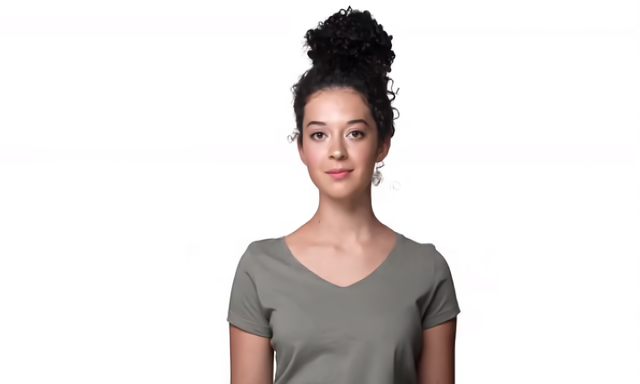

https://symbolize.stripped_domain/r/?trace=7f4fe2df946e,7f4fe2d1d08f&map= 
*** SIGTERM received by PID 1864977 (TID 1864977) on cpu 91 from PID 1867404; stack trace: ***
PC: @     0x7f4fe2df946e  (unknown)  epoll_wait
    @     0x7f4e6bce0a1a       1152  (unknown)
    @     0x7f4fe2d1d090  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=7f4fe2df946e,7f4e6bce0a19,7f4fe2d1d08f&map=ceee8fa20ddf9c34af43f587221e91de:7f4e5edb8000-7f4e6bef7840 
E0731 08:49:02.964188 1864977 coredump_hook.cc:360] RAW: Remote crash gathering disabled for SIGTERM.


: 

In [35]:
img